**Angie Carolina Joya Duarte - 2322609**  

**Sheila Marcela Valencia Chito - 2243011**

# Entrega 2 - Parte 2 - Transformer

Se escogió para este trabajo el dataset "Twitter US Airline Sentiment"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import torch
import emoji

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

from transformers import AutoTokenizer, AutoModelForSequenceClassification

from nltk.tokenize import TweetTokenizer

from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LinearLR, SequentialLR

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Funciones auxiliares para graficar

In [2]:
def graficaDistribucion (dataset, atributo, etiquetas, ejeX, ejeY, titulo):
    graphOutput = sns.countplot(x=atributo, hue=atributo, data=dataset, palette="Set2", legend=False)
    total = len(dataset)

    for p in graphOutput.patches:
        count = p.get_height() #frecuencia absoluta
        percent = 100 * count / total #frecuencia relativa

        graphOutput.annotate(f'{percent:.1f}%', # formato de texto
            (p.get_x() + p.get_width() / 2., count/2),  #posición
            ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
            textcoords='offset points')

    ticks = graphOutput.get_xticks()
    graphOutput.set_xticks(ticks)
    graphOutput.set_xticklabels(etiquetas)
    graphOutput.set_xlabel(ejeX)
    graphOutput.set_ylabel(ejeY)
    graphOutput.set_title(titulo)

    plt.show()

In [3]:
def graficaEntrenamiento(resultado, set1, set2, titulo, ylabel):
    plt.plot(resultado.history[set1], label="Entrenamiento")
    plt.plot(resultado.history[set2], label="Validación")
    plt.title(titulo)
    plt.xlabel("Época")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [4]:
def graficaMatriz(yTest_labels, yPred_labels):
  # Matriz de confusión
  cm = confusion_matrix(yTest_labels, yPred_labels)
  class_names = ['Negativo', 'Neutro', 'Positivo']

  # Graficar
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot(cmap=plt.cm.Blues)
  plt.title("Matriz de Confusión")

  plt.xlabel("Predicción")
  plt.ylabel("Etiqueta real")

  plt.show()

In [5]:
def graficaMatrizPorcentaje(y_true, y_pred):
    # Nombres de clases
    labels = ["Negativo", "Neutro", "Positivo"]

    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100
    fig, ax = plt.subplots(figsize=(7, 6))

    # Graficar
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format=".1f")

    ax.set_title("Matriz de Confusión (%)")
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Etiqueta real")

    plt.show()


Importar dataset

In [6]:
path = os.path.join(os.getcwd(), "Tweets.csv")
dataset = pd.read_csv(path, usecols=[1, 5, 10])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   airline            14640 non-null  object
 2   text               14640 non-null  object
dtypes: object(3)
memory usage: 343.3+ KB


Representamos las opiniones con etiquetas de enteros: 0 para negativa, 1 para neutral y 2 para positiva.

In [7]:
dataset = dataset.drop(["airline"], axis=1)
dataset["sentiment"] = dataset["airline_sentiment"].replace({"negative" : 0, "neutral" : 1, "positive" : 2}).astype(int)
dataset = dataset.drop(["airline_sentiment"], axis=1)

dataset.head()

C:\Users\USUARIO\AppData\Local\Temp;\ipykernel_11180\502487310.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset["sentiment"] = dataset["airline_sentiment"].replace({"negative" : 0, "neutral" : 1, "positive" : 2}).astype(int)


,text,sentiment
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica plus you've added commercials t...,2
2,@VirginAmerica I didn't today... Must mean I n...,1
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


## Transformador - BERTweet Base

Funciones de normalización de los tweets, sugeridas por los creadores de BERTweet

In [8]:
tokenizerNorm = TweetTokenizer()

def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif emoji.is_emoji(token):
        return emoji.demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token


def normalizeTweet(tweet):
    tokens = tokenizerNorm.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )

    return " ".join(normTweet.split())


### Descargar el modelo

In [9]:
modelName = "vinai/bertweet-base"

bertweet = AutoModelForSequenceClassification.from_pretrained(modelName, cache_dir="./BERTweet", num_labels=3)

tokenizer = AutoTokenizer.from_pretrained(modelName, cache_dir="./BERTweet", use_fast=True)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Preparar el dataset

Normalizar los tweets

In [10]:
dataset["textNorm"] = dataset["text"].map(normalizeTweet)
dataset.head()

,text,sentiment,textNorm
0,@VirginAmerica What @dhepburn said.,1,@USER What @USER said .
1,@VirginAmerica plus you've added commercials t...,2,@USER plus you 've added commercials to the ex...
2,@VirginAmerica I didn't today... Must mean I n...,1,@USER I did n't today ... Must mean I need to ...
3,@VirginAmerica it's really aggressive to blast...,0,@USER it 's really aggressive to blast obnoxio...
4,@VirginAmerica and it's a really big bad thing...,0,@USER and it 's a really big bad thing about it


Aplicar el tokenizador de Hugging Face

In [11]:
def tokenizar(texto):
    return tokenizer(
        texto,
        truncation=True,
        padding="max_length",
        max_length=128
    )
    
# Aplica la tokenización y convierte a diccionario
token = dataset["textNorm"].apply(lambda x: tokenizar(x))

# Crea nuevas columnas en el DataFrame
dataset["token"] = token.apply(lambda x: x["input_ids"])
dataset["mascara"] = token.apply(lambda x: x["attention_mask"])

dataset.head()

,text,sentiment,textNorm,token,mascara
0,@VirginAmerica What @dhepburn said.,1,@USER What @USER said .,"[0, 5, 165, 5, 193, 4, 2, 1, 1, 1, 1, 1, 1, 1,...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,@VirginAmerica plus you've added commercials t...,2,@USER plus you 've added commercials to the ex...,"[0, 5, 1946, 14, 120, 792, 9236, 9, 6, 1259, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ..."
2,@VirginAmerica I didn't today... Must mean I n...,1,@USER I did n't today ... Must mean I need to ...,"[0, 5, 8, 103, 29, 128, 28, 3140, 271, 8, 114,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,@VirginAmerica it's really aggressive to blast...,0,@USER it 's really aggressive to blast obnoxio...,"[0, 5, 18, 20, 116, 10063, 9, 4472, 18989, 26,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,@VirginAmerica and it's a really big bad thing...,0,@USER and it 's a really big bad thing about it,"[0, 5, 13, 18, 20, 11, 116, 312, 227, 195, 62,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."


Definir DataLoader para convertir dataset a tensores de torch

In [12]:
# Dataset ajustado a PyTorch
class TweetDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels
    
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
    
    def __len__(self):
        return len(self.labels)


Preparar conjuntos de entrenamiento, validación y prueba. 70% para entrenamiento, 15% para validación y 15% para pruebas


In [13]:
n = len(dataset)

# Dividir los datos
posTrain = int(n * 0.7)
posVal = int(n * 0.85)

# Preparar los datos para cada conjunto
listaToken = dataset["token"].tolist()
listaMascara = dataset["mascara"].tolist()
listaClase = dataset["sentiment"].tolist()

datasetTrain = TweetDataset(
    listaToken[:posTrain],
    listaMascara[:posTrain],
    listaClase[:posTrain]
)

datasetVal = TweetDataset(
    listaToken[posTrain:posVal],
    listaMascara[posTrain:posVal],
    listaClase[posTrain:posVal]
)

datasetTest = TweetDataset(
    listaToken[posVal:],
    listaMascara[posVal:],
    listaClase[posVal:]
)

print(f"Tamaño conjunto de entrenamiento: {len(datasetTrain)}")
print(f"Tamaño conjunto de validación: {len(datasetVal)}")
print(f"Tamaño conjunto de prueba: {len(datasetTest)}")


Tamaño conjunto de entrenamiento: 10248
Tamaño conjunto de validación: 2196
Tamaño conjunto de prueba: 2196


Crear DataLoaders

In [14]:
batch = 64

loaderTrain = DataLoader(datasetTrain, batch_size=batch, shuffle=True)
loaderVal = DataLoader(datasetVal, batch_size=batch, shuffle=False)
loaderTest = DataLoader(datasetTest, batch_size=batch, shuffle=False)

print(f"Número de batches de entrenamiento: {len(loaderTrain)}")
print(f"Número de batches de validación: {len(loaderVal)}")
print(f"Número de batches de prueba: {len(loaderTest)}")


Número de batches de entrenamiento: 161
Número de batches de validación: 35
Número de batches de prueba: 35


### Configurar el modelo y optimizador


In [15]:
# Configurar el dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Mover el modelo al dispositivo
bertweet.to(device)

#Congelar las 8 primeras capas (son 12 en total)
for layer_idx in range(8):
    for param in bertweet.roberta.encoder.layer[layer_idx].parameters():
        param.requires_grad = False

# Configurar el optimizador con learning rates diferenciados
# Las capas BERT entrenan más lento, el clasificador más rápido
optimizador = torch.optim.AdamW([
    {'params': bertweet.roberta.encoder.layer[8:].parameters(), 'lr': 2e-5},
    {'params': bertweet.classifier.parameters(), 'lr': 5e-5} 
], weight_decay=0.01)

# Calcular class weights para manejar el desbalanceo
etiquetas = np.array(listaClase[:posTrain])
clases = np.unique(etiquetas)
pesos = compute_class_weight(class_weight="balanced", classes=clases, y=etiquetas)
tensorPesos = torch.tensor(pesos, dtype=torch.float).to(device)

print("Class weights:", tensorPesos)

# Configurar pérdidas con class weights
criterion = torch.nn.CrossEntropyLoss(weight=tensorPesos)

# Definir épocas
epocasCalentamiento = 2
epocasTotal = 5

# Scheduler para warmup
schedulerCalentamiento = LinearLR(
    optimizador,
    start_factor=0.1,
    end_factor=1.0,
    total_iters=epocasCalentamiento
)

# Scheduler para decaimiento
schedulerDecaimineto = LinearLR(
    optimizador,
    start_factor=1.0,
    end_factor=0.1,
    total_iters=epocasTotal - epocasCalentamiento
)

# Scheduler secuencial: primero warmup, luego decaimiento
scheduler = SequentialLR(
    optimizador,
    schedulers=[schedulerCalentamiento, schedulerDecaimineto],
    milestones=[epocasCalentamiento]
)

print(f"Scheduler configurado: {epocasCalentamiento} épocas de warmup y luego decaimiento lineal")

Usando dispositivo: cpu
Class weights: tensor([0.5714, 1.4075, 1.8535])
Scheduler configurado: 2 épocas de warmup y luego decaimiento lineal


### Fine Tuning BERTweet

Definir función de entrenamiento

In [16]:
def entrenamientoBERTweet(model, train_loader, val_loader, test_loader, optimizer, criterion, device, scheduler=None, epochs=3, patience=4):
    history = {
        'loss': [],
        'accuracy': [],
        'val_loss': [],
        'val_accuracy': []
    }
    
    mejorLossVal = float('inf')
    contPaciencia = 0
    mejorModelo = None
    
    for epoca in range(epochs):
        # Fase de entrenamiento
        model.train()
        trainLoss = 0
        trainCorrect = 0
        trainTotal = 0
        
        print(f"\nÉpoca {epoca + 1}/{epochs}", flush=True)
        print_every = 50  # Imprimir cada 50 batches
        
        for batch_idx, batch in enumerate(train_loader):
            # Mover datos al dispositivo
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            # Calcular pérdida
            loss = criterion(logits, labels)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping para evitar explosión de gradientes
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Métricas
            trainLoss += loss.item()
            predictions = torch.argmax(logits, dim=1)
            trainCorrect += (predictions == labels).sum().item()
            trainTotal += labels.size(0)
            
            # Imprimir progreso cada ciertos batches
            if (batch_idx + 1) % print_every == 0:
                lossActual = trainLoss / (batch_idx + 1)
                accActual = trainCorrect / trainTotal
                print(f"  Batch {batch_idx + 1}/{len(train_loader)} - Loss: {lossActual:.4f} - Acc: {accActual:.4f}", flush=True)
        
        # Promedios de entrenamiento
        trainAvgLoss = trainLoss / len(train_loader)
        trainAcc = trainCorrect / trainTotal
        
        # Fase de validación
        model.eval()
        valLoss = 0
        valCorrect = 0
        valTotal = 0
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                
                loss = criterion(logits, labels)
                
                valLoss += loss.item()
                predictions = torch.argmax(logits, dim=1)
                valCorrect += (predictions == labels).sum().item()
                valTotal += labels.size(0)
        
        # Promedios de validación
        valAvgLoss = valLoss / len(val_loader)
        valAcc = valCorrect / valTotal
        
        # Guardar métricas
        history['loss'].append(trainAvgLoss)
        history['accuracy'].append(trainAcc)
        history['val_loss'].append(valAvgLoss)
        history['val_accuracy'].append(valAcc)
        
        # Actualizar learning rate scheduler
        if scheduler is not None:
            scheduler.step()
            lrActual = optimizer.param_groups[0]['lr']
            print(f"  Learning Rate: {lrActual:.2e}", flush=True)
        
        # Early stopping
        if valAvgLoss < mejorLossVal:
            mejorLossVal = valAvgLoss
            contPaciencia = 0
            mejorModelo = model.state_dict().copy()
        else:
            contPaciencia += 1
            if contPaciencia >= patience:
                print(f"Early stopping activado en época {epoca + 1}", flush=True)
                break
    
    # Restaurar mejor modelo
    if mejorModelo is not None:
        model.load_state_dict(mejorModelo)
        print("Modelo restaurado al mejor estado (menor val_loss)", flush=True)
    
    # Evaluación final en test
    model.eval()
    testCorrect = 0
    testTotal = 0
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            predictions = torch.argmax(logits, dim=1)
            testCorrect += (predictions == labels).sum().item()
            testTotal += labels.size(0)

    
    testAcc = testCorrect / testTotal
    print(f"\nAccuracy de pruebas: {testAcc:.4f}", flush=True)
    return history
    

Realizar Entrenamiento

In [17]:
epocas = 5

resultadoBERT = entrenamientoBERTweet(
    bertweet, 
    loaderTrain, 
    loaderVal, 
    loaderTest, 
    optimizador, 
    criterion, 
    device,
    scheduler=scheduler,  # Añadir scheduler
    epochs=epocas, 
    patience=2
)

# Mostrar resultados de primera y última época
resultados = {
    "Época": ["Primera", "Última"],
    "Loss": [resultadoBERT['loss'][0], resultadoBERT['loss'][-1]],
    "Val_Loss": [resultadoBERT['val_loss'][0], resultadoBERT['val_loss'][-1]],
    "Accuracy": [resultadoBERT['accuracy'][0], resultadoBERT['accuracy'][-1]],
    "Val_Accuracy": [resultadoBERT['val_accuracy'][0], resultadoBERT['val_accuracy'][-1]],
}

tabla = pd.DataFrame(resultados)
print("\n", tabla)



Época 1/5
  Batch 50/161 - Loss: 1.0954 - Acc: 0.2828
  Batch 100/161 - Loss: 1.0848 - Acc: 0.4247
  Batch 150/161 - Loss: 1.0700 - Acc: 0.5061
  Learning Rate: 1.10e-05

Época 2/5
  Batch 50/161 - Loss: 0.7127 - Acc: 0.7825
  Batch 100/161 - Loss: 0.6106 - Acc: 0.7973
  Batch 150/161 - Loss: 0.5558 - Acc: 0.8069
  Learning Rate: 2.00e-05

Época 3/5
  Batch 50/161 - Loss: 0.4369 - Acc: 0.8313
  Batch 100/161 - Loss: 0.4186 - Acc: 0.8387
  Batch 150/161 - Loss: 0.4197 - Acc: 0.8390
  Learning Rate: 1.40e-05

Época 4/5
  Batch 50/161 - Loss: 0.3818 - Acc: 0.8497
  Batch 100/161 - Loss: 0.3693 - Acc: 0.8533
  Batch 150/161 - Loss: 0.3670 - Acc: 0.8574
  Learning Rate: 8.00e-06

Época 5/5
  Batch 50/161 - Loss: 0.3510 - Acc: 0.8681
  Batch 100/161 - Loss: 0.3393 - Acc: 0.8728
  Batch 150/161 - Loss: 0.3329 - Acc: 0.8747
  Learning Rate: 2.00e-06
Modelo restaurado al mejor estado (menor val_loss)

Accuracy de pruebas: 0.8802

      Época      Loss  Val_Loss  Accuracy  Val_Accuracy
0  Prime

### Resultados

In [18]:
# Obtener predicciones en el conjunto de prueba
bertweet.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in loaderTest:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = bertweet(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        predictions = torch.argmax(logits, dim=1)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convertir a arrays de numpy
yPred = np.array(all_predictions)
yTest = np.array(all_labels)

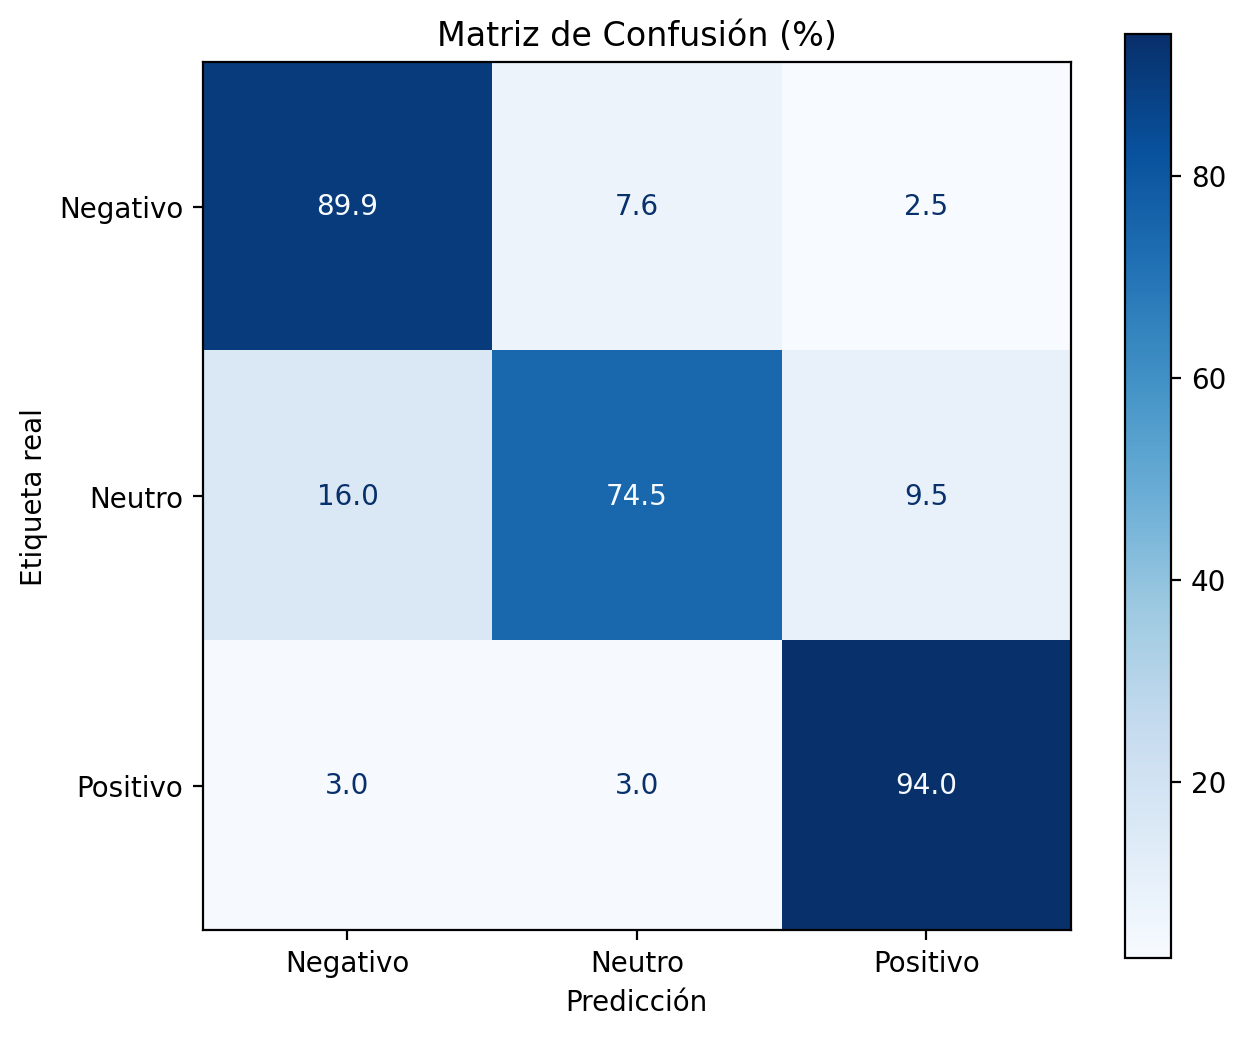

In [19]:
graficaMatrizPorcentaje(yTest, yPred)

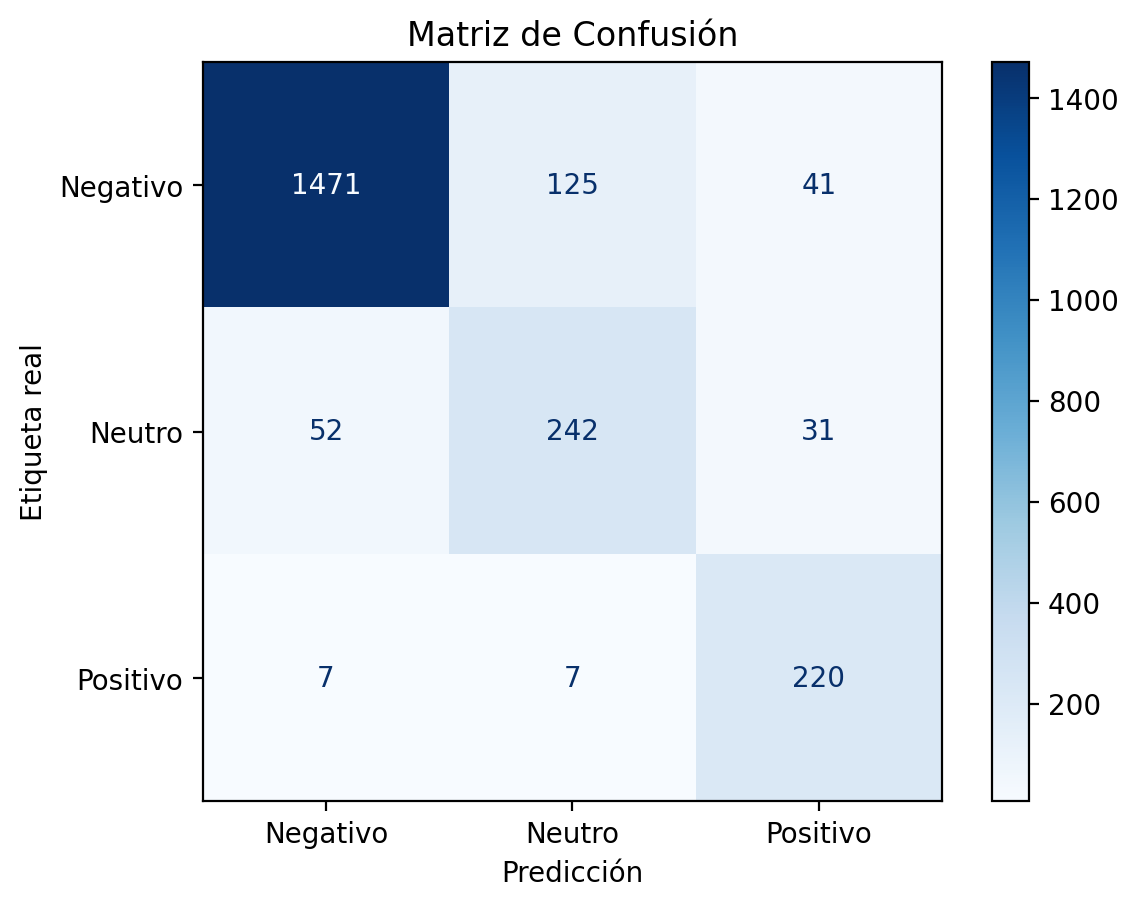

In [20]:
graficaMatriz(yTest, yPred)

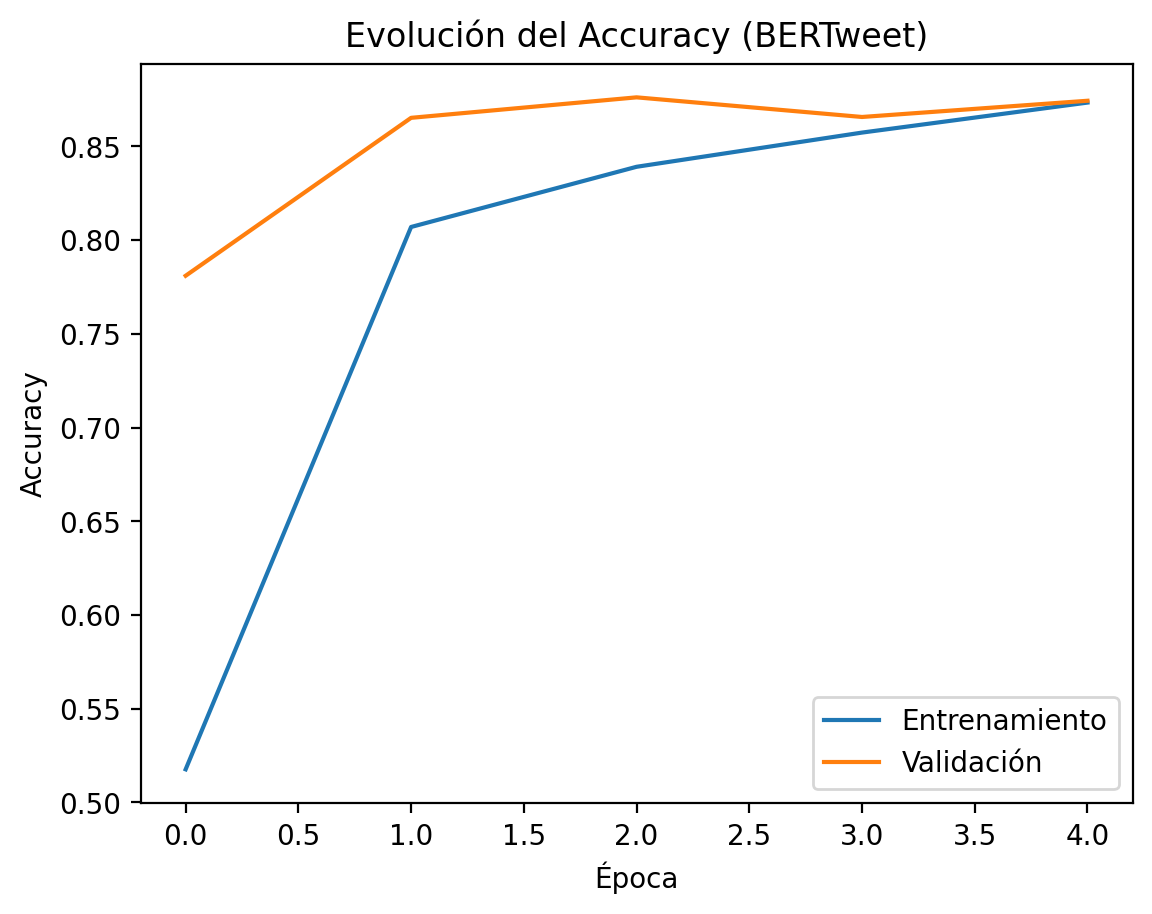

In [21]:
# Adaptar el historial para poder usar funciones graficadoras

class HistoryWrapper:
    """Wrapper para hacer que el historial de BERTweet sea compatible con la función graficaEntrenamiento"""
    def __init__(self, history_dict):
        self.history = history_dict

resultadoWrapper = HistoryWrapper(resultadoBERT)

# Graficar evolución del accuracy
graficaEntrenamiento(resultadoWrapper, "accuracy", "val_accuracy", "Evolución del Accuracy (BERTweet)", "Accuracy")


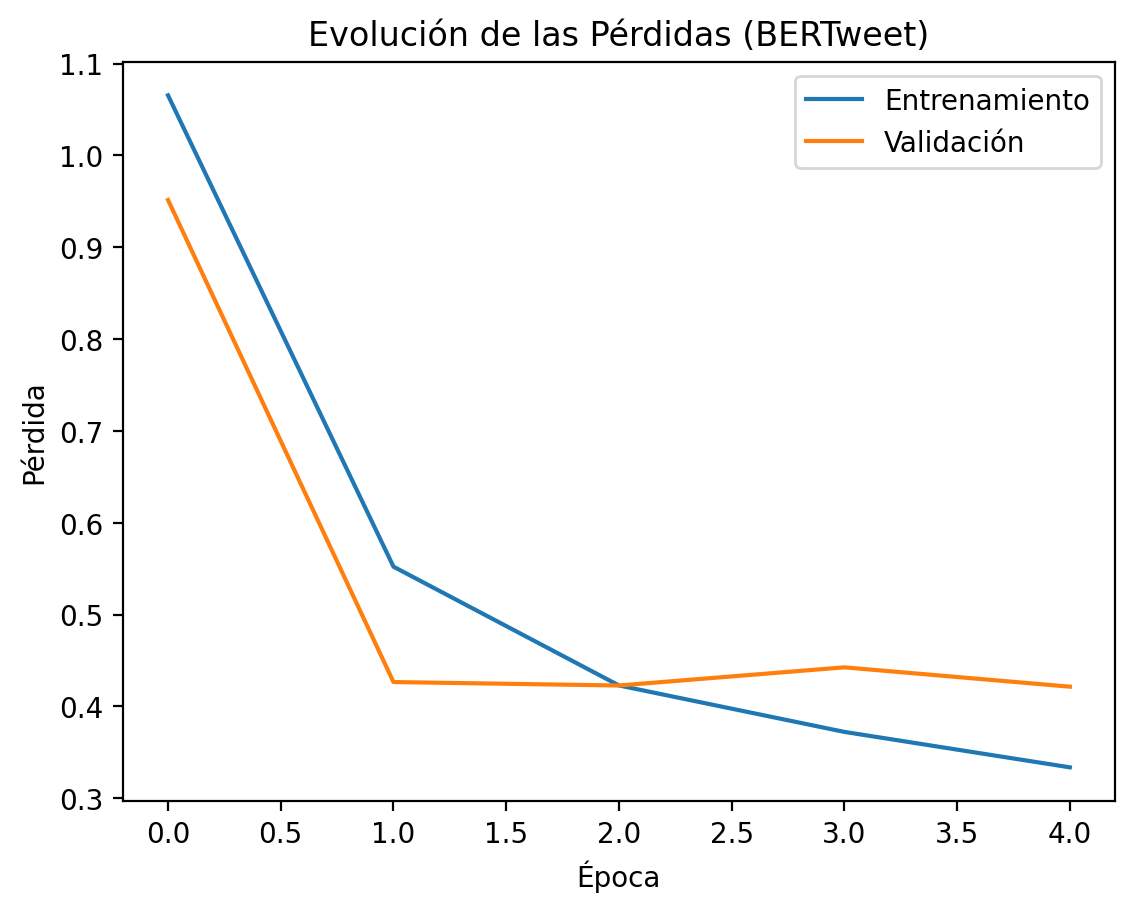

In [22]:
graficaEntrenamiento(resultadoWrapper, "loss", "val_loss", "Evolución de las Pérdidas (BERTweet)", "Pérdida")

## Pruebas Preliminares

Transfer Learning

<table>
  <tr>
    <td><img src="Imágenes/Bert1-1.png" width="300"></td>
    <td><img src="Imágenes/Bert1-2.png" width="300"></td>
    <td><img src="Imágenes/Bert1-3.png" width="300"></td>
  </tr>
</table>


Fine tuning de las últimas 4 capas con batch size 32, 10 épocas con early stopping patience 4, learning rate scheduler weight decay, y gradient clipping

<table>
  <tr>
    <td><img src="Imágenes/Bert2-1.png" width="300"></td>
    <td><img src="Imágenes/Bert2-2.png" width="300"></td>
    <td><img src="Imágenes/Bert2-3.png" width="300"></td>
  </tr>
</table>